# Miniproject weighted KNN with dataset Iris
## Menglin Xi
### Date: 14 Dez. 2020

# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

seed = 57

The famous [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) first used in R.A. Fisher's classic 1936 paper, [The Use of Multiple Measurements in Taxonomic Problems](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-1809.1936.tb02137.x)  
and can also be found on the UCI Machine Learning [Repository](http://archive.ics.uci.edu/ml/index.php).


[SKlearn](https://scikit-learn.org/stable/datasets/index.html#iris-dataset)

In this dataset 4 charachteristics (features) of the 150 flowers (samples) are measured.  
There are 3 different classes of Iris (0 setosa, 1 versicolour, 2 virginica)  
Features include sepal lenght, sepal width, petal lenght, petal width.

In [2]:
from sklearn.datasets import load_iris
'''
    we can directly use the following line to load X,y of iris dataset
    X,y = load_iris(return_X_y=True)
    instead we load iris dataset as a dataframe.
    iris, and iris_df will be used just for explaining dataframe methods
    They could also be used for visualizations.
    For processing we will use just X,y as feature vectors a nd targets
'''
iris = load_iris(as_frame=True)
iris_df = iris.frame

X = iris.data.to_numpy()
y = iris.target.to_numpy()


## Visualize the dataset

In [3]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Split data into train set, and test set

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [5]:
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler() 
#X_train = sc_x.fit_transform(X_train) 
#X_test = sc_x.transform(X_test)

## Compute the Euclidean distance


In [6]:
def compute_distances(X):
    """
    Compute the distance between each query point in X and each training point
    in X_train using no explicit loops.

    Inputs:
        - X: A numpy array of shape (Nq, D) containing query data.

    Returns:
        - dists: A numpy array of shape (Nq, N) where dists[i, j]
          is the Euclidean distance between the i-th query point and the j-th training
          point. 
    """
    num_query = X.shape[0]  #Number of query samples: Nq
    num_train = X_train.shape[0]#Number of training samples: N
    dists = np.zeros((num_query, num_train))

    X_square = np.square(X)
    X_train_T = X_train.T
    X_train_Tsqu = np.square(X_train_T)
    rowSum_X_square = np.sum(X_square, axis=1)
    rowSum_X_square.shape = (num_query, 1)
    colSum_X_train_Tsqu = np.sum(X_train_Tsqu, axis=0)
    colSum_X_train_Tsqu.shape = (1, num_train)

    # X_mul_train is Nq*N
    X_mul_train = -2 * np.dot(X, X_train_T)
    dists = X_mul_train + rowSum_X_square + colSum_X_train_Tsqu
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dists

## Weighted functions

$$
W_{trianguler} = (1- |d|)* I \\
|d|  \leqslant 1
$$

$$
W_{Epanechnikov} = \frac{3(1-d^2)}{4}*I \\
|d|  \leqslant 1
$$

$$
W_{inversion} = \frac{1}{|d|}
$$

$$
W_{Gauss} = \frac{1}{\sqrt{2\pi}}exp(-\frac{d^2}{2})
$$

$$
W_{cosine} = \frac{\pi}{4}\cos(\frac{\pi}{2}d)*I \\
|d|  \leqslant 1
$$

$$
W_{mean-one} = \mathbb{1}
$$

In [7]:
def weight_triangular(d):
    '''
        w = (1-|d|)*I(|d|<=1)
    '''
    return 1.0-d

def weight_Epanechnikov(d):
    '''
        w = 3/4*(1-d*d)*I(|d|<=1)
    '''
    return (3/4)*(1-np.multiply(d,d))

def weight_inversion(d):
    '''
        w = 1/|d|
    '''
    return 1.0/d
def weight_one(d):
    '''
        this means every points have the same weight
    '''
    return np.ones(d.shape[0])

def weight_Gauss(d):
    return 1.0/np.sqrt(2*np.pi)*np.exp(-np.multiply(d,d)/2.0)

def weight_cosine(d):
    return np.pi/4*np.cos(0.5*np.pi*d)

## Predict function

In [8]:
def predict(dists, weight, k = 5, trainORtest = True, y_check = y_train):
    '''
        Given a matrix of distances between query points and training points,
        predict a label for each query point.

        BUT when the trainORtest = true, we use training set as query points, so the nearest point is itself,
        so we use the [1:k+1] points to calculate the predict value.

        AND When the trainORtest = False, we use testing set as query points, so the nearest point is itself,
        so we use the [0:k] points to calculate the predict value.



        Inputs:
        - dists: A numpy array of shape (num_query, num_train) where dists[i, j]
          gives the distance betwen the ith query point and the jth training point.
        - weight: use which weighted function
        - k: the nearest k points
        - trainORtest: use which dateset
        - y_check: the target of train set

        Returns:
        - y: A numpy array of shape (num_query,) containing predicted labels for the
          query data, where y[i] is the predicted label for the query point X[i].
    '''
    num_query = dists.shape[0]#Number of query samples: Nq
    y_pred_knn = np.zeros(num_query)
    y_pred_wknn = np.zeros(num_query)
    for i in range(num_query):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith query point.
        closest_ky = []
        closest_wky = []    
        sort_index_dists = np.argsort(dists[i])
        sort_dists = np.sort(dists[i])

        if(trainORtest):
            sort_index_dists = sort_index_dists[1:k+1]
            sort_k_dists = sort_dists[1:k+1]
            stand_dists = sort_dists[k+1]
        else:
            sort_index_dists = sort_index_dists[0:k]
            sort_k_dists = sort_dists[0:k]
            stand_dists = sort_dists[k]
    
        for index in sort_index_dists:
            closest_ky.append(y_check[index])
            closest_wky.append(y_check[index])

        if weight == weight_Gauss or weight_inversion:
            weight_ditst = weight(sort_k_dists)
        else:
            weight_ditst = weight(sort_k_dists/stand_dists)
            
        closest_wky_set = list((set(closest_wky)))# closest_wky_set = [0, 1, 2] for iris
        closest_y = np.zeros(len(closest_wky_set))# len(set) = 3
        
        for index in range(0,len(closest_wky)):
            set_index = closest_wky_set.index(closest_wky[index])
            closest_y[set_index] += weight_ditst[index]
           
        closest_y = list(closest_y)
        y_pred_knn[i] = max(closest_ky, key=closest_ky.count)
        y_pred_wknn[i] = closest_wky_set[closest_y.index(max(closest_y))]

    return y_pred_knn, y_pred_wknn

### show the result of training set, the weight-function can be replaced

In [9]:
distance_train = compute_distances(X_train)
y_hat_train_knn, y_hat_train_wknn = predict(distance_train, weight_inversion, k = 5 , trainORtest = True, y_check = y_train)
num_train = y_train.shape[0]
num_correct_knn = np.sum(y_hat_train_knn == y_train)
num_correct_wknn = np.sum(y_hat_train_wknn == y_train)
accuracy_knn = float(num_correct_knn) / num_train
accuracy_wknn = float(num_correct_wknn) / num_train
print('KNN  Got %d / %d correct => accuracy: %f' % (num_correct_knn, num_train, accuracy_knn))
print('WKNN Got %d / %d correct => accuracy: %f' % (num_correct_wknn, num_train, accuracy_wknn))

KNN  Got 113 / 120 correct => accuracy: 0.941667
WKNN Got 113 / 120 correct => accuracy: 0.941667


### show the result of training set, the weight-function can be replaced

In [10]:
distance_test = compute_distances(X_test)
y_hat_test_knn, y_hat_test_wknn = predict(distance_test, weight_inversion, k = 5, trainORtest = False, y_check = y_train)
num_test = y_test.shape[0]
num_correct_knn = np.sum(y_hat_test_knn == y_test)
num_correct_wknn = np.sum(y_hat_test_wknn == y_test)
accuracy_knn = float(num_correct_knn) / num_test
accuracy_wknn = float(num_correct_wknn) / num_test
print('KNN  Got %d / %d correct => accuracy: %f' % (num_correct_knn, num_test, accuracy_knn))
print('WKNN Got %d / %d correct => accuracy: %f' % (num_correct_wknn, num_test, accuracy_wknn))

KNN  Got 30 / 30 correct => accuracy: 1.000000
WKNN Got 30 / 30 correct => accuracy: 1.000000


## View the impact of different training sets and test sets on the results
### use different seed

In [28]:
seedlist = range(13,133,6)
train_knn_correct = []
train_wknn_correct = []
test_knn_correct = []
test_wknn_correct = []
for seed in seedlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
    distance_train = compute_distances(X_train)
    distance_test = compute_distances(X_test)
    num_train = y_train.shape[0]
    num_test = y_test.shape[0]

    print("Seed = %d" % seed)
    y_hat_train_knn, y_hat_train_wknn = predict(distance_train, weight_inversion, k = 3 , trainORtest = True, y_check = y_train)

    num_correct_knn = np.sum(y_hat_train_knn == y_train)
    num_correct_wknn = np.sum(y_hat_train_wknn == y_train)
    accuracy_knn = float(num_correct_knn) / num_train
    accuracy_wknn = float(num_correct_wknn) / num_train
    train_knn_correct.append(accuracy_knn)
    train_wknn_correct.append(accuracy_wknn)
    print('Train KNN    Got %d / %d correct => accuracy: %f' % (num_correct_knn, num_train, accuracy_knn))
    print('Train WKNN   Got %d / %d correct => accuracy: %f' % (num_correct_wknn, num_train, accuracy_wknn))



    y_hat_test_knn, y_hat_test_wknn = predict(distance_test, weight_inversion, k = 3, trainORtest = False, y_check = y_train)

    num_correct_knn = np.sum(y_hat_test_knn == y_test)
    num_correct_wknn = np.sum(y_hat_test_wknn == y_test)
    accuracy_knn = float(num_correct_knn) / num_test
    accuracy_wknn = float(num_correct_wknn) / num_test
    test_knn_correct.append(accuracy_knn)
    test_wknn_correct.append(accuracy_wknn)
    print('Test KNN     Got %d / %d correct => accuracy: %f' % (num_correct_knn, num_test, accuracy_knn))
    print('Test WKNN    Got %d / %d correct => accuracy: %f' % (num_correct_wknn, num_test, accuracy_wknn))
    print('\n')

Seed = 13
Train KNN    Got 114 / 120 correct => accuracy: 0.950000
Train WKNN   Got 114 / 120 correct => accuracy: 0.950000
Test KNN     Got 29 / 30 correct => accuracy: 0.966667
Test WKNN    Got 29 / 30 correct => accuracy: 0.966667


Seed = 19
Train KNN    Got 114 / 120 correct => accuracy: 0.950000
Train WKNN   Got 114 / 120 correct => accuracy: 0.950000
Test KNN     Got 30 / 30 correct => accuracy: 1.000000
Test WKNN    Got 30 / 30 correct => accuracy: 1.000000


Seed = 25
Train KNN    Got 117 / 120 correct => accuracy: 0.975000
Train WKNN   Got 117 / 120 correct => accuracy: 0.975000
Test KNN     Got 28 / 30 correct => accuracy: 0.933333
Test WKNN    Got 28 / 30 correct => accuracy: 0.933333


Seed = 31
Train KNN    Got 117 / 120 correct => accuracy: 0.975000
Train WKNN   Got 117 / 120 correct => accuracy: 0.975000
Test KNN     Got 28 / 30 correct => accuracy: 0.933333
Test WKNN    Got 28 / 30 correct => accuracy: 0.933333


Seed = 37
Train KNN    Got 117 / 120 correct => accuracy

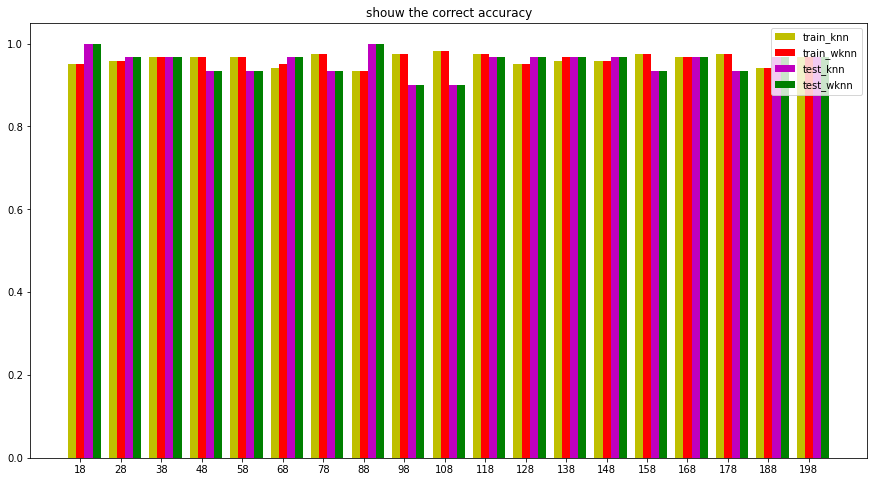

In [25]:
plt.figure(1,[15,8])
plt.title("shouw the correct accuracy")
num_list1 = [1,2,3,1]
x =list(range(len(seedlist)))
total_width, n = 0.8, 4
width = total_width / n
 #tick_label = seedlist
plt.bar(x, train_knn_correct, width=width, label='train_knn',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, train_wknn_correct, width=width, label='train_wknn',tick_label = seedlist,fc = 'r')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_knn_correct, width=width, label='test_knn',fc = 'm')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_wknn_correct, width=width, label='test_wknn',fc = 'g')
plt.legend()
plt.show()